# 端到端 VQ-VAE 训练：完整版 GCPNet + Transformer + VQ + Decoder

本 notebook 实现**完整的端到端训练流程**，适配升级后的 GCPNet 架构。

## ✨ 更新内容（2025-12-03）

### 架构升级
- **GCPNet 编码器**：完整版 6 层架构（128维标量 + 16维向量特征）
- **特征提取器**：包含 alpha、kappa、dihedrals 等完整几何特征
- **配体/相互作用编码器**：从简单 MLP 升级为 GCPNet 架构
- **特征维度**：边级融合特征从 257 维升级为更高维度（取决于 GCPNet 输出）

### 关键差异

| 项目 | 旧版本 | 新版本（升级后） |
|------|--------|-----------------|
| **蛋白编码器** | 简化版 GCPNet（39维输入） | 完整版 GCPNet（49维输入） |
| **配体编码器** | SimpleLigandEncoder MLP | GCPNet 架构 |
| **相互作用编码器** | SimpleLigandEncoder MLP | GCPNet 架构 |
| **特征维度** | 257 维 | 641 维（128*3 + 257） |
| **训练模式** | 端到端可训练 | 端到端可训练 |

## 数据来源

使用 `feature extraction/full_pipeline.py` 生成的 HDF5 数据：
- `improtant data/binding_edge_features_fused.h5` - 边级融合特征（641 维）

## 训练流程

1. 加载 HDF5 数据
2. 构建完整模型：完整版 GCPNet + Featuriser + VQ-VAE
3. 设置分层学习率优化器
4. 端到端训练（梯度回传到 GCPNet）
5. 保存 checkpoint
6. 推理验证

## Step 1：环境配置与路径设置

In [1]:
from pathlib import Path
import sys

import numpy as np
import pandas as pd
import h5py

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torch.cuda.amp import autocast, GradScaler

from omegaconf import OmegaConf
import logging

# 路径配置
BASE_DIR = Path(r'c:/Users/Administrator/Desktop/IGEM/stage1/notebook-lab')
sys.path.insert(0, str(BASE_DIR))

# 数据路径
H5_DATA_PATH = BASE_DIR / 'improtant data' / 'binding_edge_features_fused.h5'
CHECKPOINT_DIR = BASE_DIR / 'checkpoints' / 'vqvae_end_to_end'
CHECKPOINT_DIR.mkdir(parents=True, exist_ok=True)

# 配置文件
VQVAE_CONFIG = BASE_DIR / 'config_vqvae.yaml'
GCPNET_CONFIG = BASE_DIR / 'config_gcpnet_encoder.yaml'

# 设备
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Device: {device}')
print(f'CUDA available: {torch.cuda.is_available()}')
if torch.cuda.is_available():
    print(f'GPU: {torch.cuda.get_device_name(0)}')
    print(f'GPU Memory: {torch.cuda.get_device_properties(0).total_memory / 1e9:.2f} GB')

Device: cuda
CUDA available: True
GPU: NVIDIA GeForce RTX 5060 Ti
GPU Memory: 17.10 GB


## Step 1.5：数据预处理（可选）

如果 HDF5 数据文件不存在，运行此 cell 自动生成数据。

**注意**：此步骤需要 10-30 分钟，取决于机器性能。

In [2]:
# 检查 HDF5 数据文件是否存在
print('[Data Check] Checking for HDF5 data file...')
print(f'  Looking for: {H5_DATA_PATH}')

if H5_DATA_PATH.exists():
    print(f'  ✓ HDF5 data file found!')
    print(f'  File size: {H5_DATA_PATH.stat().st_size / 1e6:.2f} MB')
    
    # 快速检查数据
    with h5py.File(H5_DATA_PATH, 'r') as f:
        num_edges = f.attrs.get('num_edges', 'unknown')
        feature_dim = f.attrs.get('feature_dim', 'unknown')
        print(f'  Num edges: {num_edges}')
        print(f'  Feature dim: {feature_dim}')
    
    print('\\n  → Skip to Step 2 to load data')
else:
    print(f'  ✗ HDF5 data file not found!')
    print(f'\\n  → Run the cell below to generate data automatically')
    print(f'  → Or manually run: python "feature extraction/full_pipeline.py"')

[Data Check] Checking for HDF5 data file...
  Looking for: c:\Users\Administrator\Desktop\IGEM\stage1\notebook-lab\improtant data\binding_edge_features_fused.h5
  ✓ HDF5 data file found!
  File size: 33.28 MB
  Num edges: 12856
  Feature dim: 641
\n  → Skip to Step 2 to load data


### 自动运行 full_pipeline.py 生成数据

**运行此 cell 将自动执行完整的数据处理流程**：

1. 分析 3432 个 PDB 文件，识别蛋白-配体接触
2. 构建三张图（蛋白、配体、相互作用）并用 GCPNet 编码
3. 提取边级局部特征
4. 融合四个文件生成最终的 `binding_edge_features_fused.h5`

**预计时间**：10-30 分钟

**输出位置**：`improtant data/` 目录下的 6 个 HDF5 文件

In [ ]:
# 自动运行 full_pipeline.py 生成数据
# 只有在数据文件不存在时才运行

if not H5_DATA_PATH.exists():
    print('=' * 70)
    print('开始运行 full_pipeline.py 生成 HDF5 数据')
    print('=' * 70)
    print('\\n⚠ 此过程需要 10-30 分钟，请耐心等待...\\n')
    
    # 导入 full_pipeline 模块
    pipeline_script = BASE_DIR / 'feature extraction' / 'full_pipeline.py'
    
    if not pipeline_script.exists():
        raise FileNotFoundError(
            f"找不到 full_pipeline.py: {pipeline_script}\\n"
            f"请确认文件路径是否正确"
        )
    
    # 方法 1：直接导入并运行（推荐）
    try:
        import importlib.util
        spec = importlib.util.spec_from_file_location("full_pipeline", pipeline_script)
        full_pipeline = importlib.util.module_from_spec(spec)
        spec.loader.exec_module(full_pipeline)
        
        # 运行主函数
        print('\\n开始执行 full_pipeline.main()...\\n')
        full_pipeline.main()
        
        print('\\n' + '=' * 70)
        print('✓ 数据生成完成！')
        print('=' * 70)
        
        # 验证文件是否生成
        if H5_DATA_PATH.exists():
            print(f'\\n✓ 成功生成: {H5_DATA_PATH}')
            print(f'  File size: {H5_DATA_PATH.stat().st_size / 1e6:.2f} MB')
            
            with h5py.File(H5_DATA_PATH, 'r') as f:
                num_edges = f.attrs.get('num_edges', 'unknown')
                feature_dim = f.attrs.get('feature_dim', 'unknown')
                print(f'  Num edges: {num_edges}')
                print(f'  Feature dim: {feature_dim}')
        else:
            print('\\n⚠ 警告：数据文件未生成，请检查 full_pipeline.py 的输出')
    
    except Exception as e:
        print(f'\\n✗ 运行 full_pipeline.py 时出错: {e}')
        print('\\n请尝试手动运行：')
        print(f'  cd "{BASE_DIR / "feature extraction"}"')
        print(f'  python full_pipeline.py')
        raise

else:
    print('✓ HDF5 数据文件已存在，跳过数据生成步骤')
    print(f'  文件路径: {H5_DATA_PATH}')
    print('\\n→ 继续执行 Step 2 加载数据')

## Step 2：数据集定义

In [ ]:
class EdgeFeatureDataset(Dataset):
    """
    从 HDF5 文件加载边级融合特征。
    
    数据来源：feature extraction/full_pipeline.py 生成的
    improtant data/binding_edge_features_fused.h5
    
    包含：
    - features: (N_edges, feature_dim) 融合特征矩阵
      * 旧版本：257 维（简化 GCPNet）
      * 新版本：641 维（完整 GCPNet）
    - 元信息：pdb_id, ligand_resname, graph_index, etc.
    """
    def __init__(self, h5_path, max_edges_per_sample=512):
        self.h5_path = h5_path
        self.max_edges = max_edges_per_sample
         
        with h5py.File(h5_path, 'r') as f:
            self.features = f['features'][:]
            self.graph_indices = f['graph_index'][:]
            self.num_edges = len(self.features)
            self.num_graphs = int(self.graph_indices.max()) + 1
            
            # 读取元信息
            self.pdb_ids = f['pdb_id'][:].astype(str)
            self.ligand_resnames = f['ligand_resname'][:].astype(str)
            
            # 读取属性信息
            self.feature_dim = f.attrs.get('feature_dim', self.features.shape[1])
            self.edge_feature_dim = f.attrs.get('edge_feature_dim', 'unknown')
            self.protein_emb_dim = f.attrs.get('protein_emb_dim', 'unknown')
            self.ligand_emb_dim = f.attrs.get('ligand_emb_dim', 'unknown')
            self.interaction_emb_dim = f.attrs.get('interaction_emb_dim', 'unknown')
        
        print(f'  Loaded {self.num_edges} edges from {self.num_graphs} graphs')
        print(f'  Feature dim: {self.features.shape[1]}')
        print(f'  Feature composition:')
        print(f'    - Edge local features: {self.edge_feature_dim}')
        print(f'    - Protein embedding: {self.protein_emb_dim}')
        print(f'    - Ligand embedding: {self.ligand_emb_dim}')
        print(f'    - Interaction embedding: {self.interaction_emb_dim}')
        print(f'  Max edges per sample: {self.max_edges}')
    
    def __len__(self):
        return self.num_graphs
    
    def __getitem__(self, idx):
        # 获取属于该图的所有边
        mask_graph = (self.graph_indices == idx)
        graph_features = self.features[mask_graph]
        
        # 截断或填充到固定长度
        num_edges = len(graph_features)
        if num_edges > self.max_edges:
            graph_features = graph_features[:self.max_edges]
            num_edges = self.max_edges
        
        # 创建 mask（1 表示有效边，0 表示填充）
        mask = torch.zeros(self.max_edges, dtype=torch.float32)
        mask[:num_edges] = 1.0
        
        # 填充到固定长度
        padded_features = np.zeros((self.max_edges, self.features.shape[1]), dtype=np.float32)
        padded_features[:num_edges] = graph_features
        
        return torch.from_numpy(padded_features), mask


# 加载数据集
print('\n[Dataset] Loading edge feature dataset...')
dataset = EdgeFeatureDataset(H5_DATA_PATH, max_edges_per_sample=512)
print(f'\n✓ Dataset loaded: {len(dataset)} samples')
print(f'\n💡 特征维度说明：')
print(f'  如果是 641 维 → 使用完整版 GCPNet（推荐）')
print(f'  如果是 257 维 → 使用简化版 GCPNet（旧版本）')


[Dataset] Loading edge feature dataset...
  Loaded 12856 edges from 3139 graphs
  Feature dim: 641
  Max edges per sample: 512

✓ Dataset loaded: 3139 samples


## 🔄 架构升级说明

### 完整版 GCPNet 特征

**旧版本（简化版）：**
- 节点特征：`amino_acid_one_hot` (23) + `sequence_positional_encoding` (16) = **39 维**
- 向量特征：`orientation` (2 维)

**新版本（完整版）：**
- 节点特征：
  - `amino_acid_one_hot` (23)
  - `sequence_positional_encoding` (16)
  - `alpha` (1) - 虚拟扭转角
  - `kappa` (1) - 虚拟弯曲角
  - `dihedrals` (8) - 二面角特征
  - **总计：49 维**
- 向量特征：`orientation` (2 维)

### 编码器架构对比

| 组件 | 旧版本 | 新版本 |
|------|--------|--------|
| **蛋白编码器** | 简化 GCPNet (39维输入) | 完整 GCPNet (49维输入) |
| **配体编码器** | SimpleLigandEncoder (MLP) | GCPNet 架构 |
| **相互作用编码器** | SimpleLigandEncoder (MLP) | GCPNet 架构 |
| **输出维度** | 128 维 | 128 维 |

### 融合特征维度

- **蛋白 embedding**: 128 维（GCPNet 输出）
- **配体 embedding**: 128 维（GCPNet 输出）
- **相互作用 embedding**: 128 维（GCPNet 输出）
- **边级局部特征**: 257 维（节点特征 + 距离）
- **融合后总维度**: 128 + 128 + 128 + 257 = **641 维**

### 预期效果

✅ **更丰富的几何特征**：包含完整的蛋白质几何信息（角度、曲率等）  
✅ **统一的编码架构**：三种图都使用 GCPNet，表示能力更强  
✅ **更好的泛化能力**：完整特征有助于捕获复杂的蛋白-配体相互作用

## Step 3：模型构建（端到端版本）

In [ ]:
from vqvae import VQVAETransformer
from gcpnet.models.graph_encoders.gcpnet import GCPNetModel
from gcpnet.features.factory import ProteinFeaturiser
from types import SimpleNamespace

print('\n[Model] Building end-to-end architecture with upgraded GCPNet...')

# ------------------ 1. 加载配置 ------------------
vqvae_configs = OmegaConf.load(str(VQVAE_CONFIG))
gcpnet_configs = OmegaConf.load(str(GCPNET_CONFIG))

# ------------------ 2. 构建完整版 GCPNet（可训练模式）------------------
print('\n[GCPNet] Building full GCPNet encoder...')

# 完整版 Featuriser（匹配 config_gcpnet_encoder.yaml）
featuriser = ProteinFeaturiser(
    representation="CA",
    scalar_node_features=[
        "amino_acid_one_hot",
        "sequence_positional_encoding",
        "alpha",
        "kappa",
        "dihedrals"
    ],
    vector_node_features=["orientation"],
    edge_types=["knn_16"],
    scalar_edge_features=["edge_distance"],
    vector_edge_features=["edge_vectors"],
).to(device)
featuriser.train()  # ← 关键：设置为训练模式

# 转换配置为可用格式
def dict_to_namespace(d):
    """递归地将字典转换为 SimpleNamespace"""
    if isinstance(d, dict):
        return SimpleNamespace(**{k: dict_to_namespace(v) for k, v in d.items()})
    elif isinstance(d, list):
        return [dict_to_namespace(item) for item in d]
    else:
        return d

enc_kwargs_dict = OmegaConf.to_container(gcpnet_configs.encoder.kwargs, resolve=True)

# 构建 GCPNet encoder 参数
gcpnet_kwargs = {
    'num_layers': enc_kwargs_dict['num_layers'],
    'emb_dim': enc_kwargs_dict['emb_dim'],
    'node_s_emb_dim': enc_kwargs_dict['node_s_emb_dim'],
    'node_v_emb_dim': enc_kwargs_dict['node_v_emb_dim'],
    'edge_s_emb_dim': enc_kwargs_dict['edge_s_emb_dim'],
    'edge_v_emb_dim': enc_kwargs_dict['edge_v_emb_dim'],
    'r_max': enc_kwargs_dict['r_max'],
    'num_rbf': enc_kwargs_dict['num_rbf'],
    'activation': enc_kwargs_dict['activation'],
    'pool': enc_kwargs_dict['pool'],
    'module_cfg': dict_to_namespace(enc_kwargs_dict['module_cfg']),
    'model_cfg': dict_to_namespace(enc_kwargs_dict['model_cfg']),
    'layer_cfg': dict_to_namespace(enc_kwargs_dict['layer_cfg']),
}

gcpnet_encoder = GCPNetModel(**gcpnet_kwargs).to(device)
gcpnet_encoder.train()  # ← 关键：设置为训练模式

print(f'  ✓ Full GCPNet encoder initialized')
print(f'    - Layers: {gcpnet_kwargs["num_layers"]}')
print(f'    - Node scalar dim: {gcpnet_kwargs["node_s_emb_dim"]}')
print(f'    - Node vector dim: {gcpnet_kwargs["node_v_emb_dim"]}')
print(f'    - Input features: amino_acid_one_hot + seq_pos + alpha + kappa + dihedrals')

# 可选：加载预训练权重
gcpnet_ckpt_path = BASE_DIR / 'models' / 'checkpoints' / 'structure_denoising' / 'gcpnet' / 'ca_bb' / 'last.ckpt'
if gcpnet_ckpt_path.exists():
    try:
        ckpt = torch.load(gcpnet_ckpt_path, map_location=device)
        gcpnet_encoder.load_state_dict(ckpt['state_dict'], strict=False)
        print('  ✓ Loaded GCPNet pretrained weights for fine-tuning')
    except Exception as e:
        print(f'  ⚠ Failed to load checkpoint: {e}')
        print('  → Using random initialization')
else:
    print('  ⚠ GCPNet checkpoint not found, using random init')

print(f'  GCPNet mode: {"TRAIN" if gcpnet_encoder.training else "EVAL"}')
print(f'  Featuriser mode: {"TRAIN" if featuriser.training else "EVAL"}')

# ------------------ 3. 特征投影层 ------------------
# 检查实际的特征维度
with h5py.File(H5_DATA_PATH, 'r') as f:
    actual_feature_dim = f['features'].shape[1]
    print(f'\n[Data] Actual feature dimension from HDF5: {actual_feature_dim}')

class FeatureProjector(nn.Module):
    """将边级融合特征投影到 VQ 空间（128维）"""
    def __init__(self, in_dim, out_dim=128):
        super().__init__()
        self.proj = nn.Sequential(
            nn.Linear(in_dim, 512),
            nn.LayerNorm(512),
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Linear(512, out_dim),
        )
    
    def forward(self, x):
        return self.proj(x)

feature_projector = FeatureProjector(in_dim=actual_feature_dim, out_dim=128).to(device)
print(f'\n[Projector] Feature projector: {actual_feature_dim} -> 128 dim')

# ------------------ 4. 构建 VQ-VAE ------------------
print('\n[VQ-VAE] Building VQVAETransformer...')

logger = logging.getLogger('end_to_end_vqvae')
if not logger.handlers:
    handler = logging.StreamHandler()
    formatter = logging.Formatter('[%(levelname)s] %(message)s')
    handler.setFormatter(formatter)
    logger.addHandler(handler)
logger.setLevel(logging.INFO)

# Decoder：将 VQ 输出（128维）重建回原始特征空间
class ReconstructionDecoder(nn.Module):
    """重建解码器：VQ 输出 -> 原始特征空间"""
    def __init__(self, vq_dim: int, output_dim: int):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(vq_dim, 512),
            nn.LayerNorm(512),
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Linear(512, output_dim),
        )
    
    def forward(self, x, valid, true_lengths=None):
        # x: (B, L, vq_dim)
        return self.net(x)  # (B, L, output_dim)

vq_dim = vqvae_configs.model.vqvae.vector_quantization.dim
output_dim = actual_feature_dim  # 使用实际的特征维度

decoder = ReconstructionDecoder(vq_dim, output_dim).to(device)
print(f'  ✓ Using ReconstructionDecoder: {vq_dim} -> {output_dim} dim')

# 🔧 禁用 TikTok 压缩（避免序列长度变化）
if hasattr(vqvae_configs.model.vqvae.vector_quantization, 'tik_tok'):
    vqvae_configs.model.vqvae.vector_quantization.tik_tok.enabled = False
    print('  ⚠ Disabled TikTok compression to maintain sequence length')

# 禁用 kmeans_init（训练时会自动初始化）
original_kmeans_init = vqvae_configs.model.vqvae.vector_quantization.kmeans_init
vqvae_configs.model.vqvae.vector_quantization.kmeans_init = False

vqvae_model = VQVAETransformer(
    vqvae_configs,
    decoder=decoder,
    logger=logger,
    decoder_only=False
).to(device)

vqvae_configs.model.vqvae.vector_quantization.kmeans_init = original_kmeans_init

# 检查是否启用了 Residual VQ
tik_tok_cfg = vqvae_configs.model.vqvae.vector_quantization.tik_tok
residual_depth = tik_tok_cfg.get('residual_depth', 1)
use_residual_vq = residual_depth > 1

print(f'  ✓ VQVAETransformer built')
print(f'    - Encoder: {vqvae_configs.model.vqvae.encoder.depth} layers, {vqvae_configs.model.vqvae.encoder.dimension} dim')
print(f'    - VQ: {vqvae_configs.model.vqvae.vector_quantization.codebook_size} codes, {vq_dim} dim')
print(f'    - Residual VQ: {"enabled" if use_residual_vq else "disabled"} ({residual_depth} layers)')
print(f'    - TikTok compression: disabled (sequence length preserved)')
print(f'    - Orthogonal regularization: weight={vqvae_configs.model.vqvae.vector_quantization.orthogonal_reg_weight}')

if use_residual_vq:
    total_codebook_combinations = vqvae_configs.model.vqvae.vector_quantization.codebook_size ** residual_depth
    print(f'    - Total codebook combinations: {total_codebook_combinations:,} (4096^{residual_depth})')

print('\n✓ 端到端模型构建完成（使用完整版 GCPNet）！')


[Model] Building end-to-end architecture...

[GCPNet] Building GCPNet encoder...
  ⚠ GCPNet checkpoint not found, using random init
  GCPNet mode: TRAIN
  Featuriser mode: TRAIN

[Projector] Feature projector: 641 -> 128 dim

[VQ-VAE] Building VQVAETransformer...
  ✓ Using ReconstructionDecoder: 128 -> 641 dim
  ⚠ Disabled TikTok compression to maintain sequence length
  ✓ VQVAETransformer built
    - Encoder: 8 layers, 1024 dim
    - VQ: 4096 codes, 128 dim
    - Residual VQ: enabled (4 layers)
    - TikTok compression: disabled (sequence length preserved)
    - Total codebook combinations: 281,474,976,710,656 (4096^4)

✓ 端到端模型构建完成！


## Step 4：优化器配置（分层学习率）

In [15]:
print('\n[Optimizer] Setting up layered learning rates...')

# 分层学习率：GCPNet 用小学习率，其他模块用正常学习率
base_lr = 1e-4
gcpnet_lr = 1e-5  # GCPNet 用 10 倍小的学习率

param_groups = [
    {
        'params': gcpnet_encoder.parameters(),
        'lr': gcpnet_lr,
        'name': 'gcpnet_encoder'
    },
    {
        'params': featuriser.parameters(),
        'lr': gcpnet_lr,
        'name': 'featuriser'
    },
    {
        'params': feature_projector.parameters(),
        'lr': base_lr,
        'name': 'feature_projector'
    },
    {
        'params': vqvae_model.parameters(),
        'lr': base_lr,
        'name': 'vqvae_model'
    },
]

optimizer = torch.optim.AdamW(
    param_groups,
    weight_decay=0.01,
    betas=(0.9, 0.999),
    eps=1e-8,
)

print(f'  ✓ Optimizer configured with layered learning rates:')
print(f'    - GCPNet encoder: {gcpnet_lr}')
print(f'    - Featuriser: {gcpnet_lr}')
print(f'    - Feature projector: {base_lr}')
print(f'    - VQ-VAE: {base_lr}')

# 学习率调度器
from torch.optim.lr_scheduler import CosineAnnealingWarmRestarts

scheduler = CosineAnnealingWarmRestarts(
    optimizer,
    T_0=10,  # 每 10 个 epoch 重启一次
    T_mult=2,
    eta_min=1e-6,
)

print(f'  ✓ Scheduler: CosineAnnealingWarmRestarts (T_0=10, T_mult=2)')

# 混合精度训练
use_amp = torch.cuda.is_available()
scaler = GradScaler() if use_amp else None
print(f'  Mixed precision (AMP): {"enabled" if use_amp else "disabled"}')


[Optimizer] Setting up layered learning rates...
  ✓ Optimizer configured with layered learning rates:
    - GCPNet encoder: 1e-05
    - Featuriser: 1e-05
    - Feature projector: 0.0001
    - VQ-VAE: 0.0001
  ✓ Scheduler: CosineAnnealingWarmRestarts (T_0=10, T_mult=2)


C:\Users\Administrator\AppData\Local\Temp\ipykernel_43572\195941871.py:57: FutureWarning:

`torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.



  Mixed precision (AMP): enabled


## Step 5：损失函数定义

In [ ]:
def compute_reconstruction_loss(pred, target, mask):
    """
    计算重建损失（特征空间 MSE）
    
    Args:
        pred: (B, L, D) 预测特征
        target: (B, L, D) 目标特征
        mask: (B, L) 有效位置掩码
    
    Returns:
        loss: 标量损失
    """
    diff = (pred - target) ** 2
    loss = (diff * mask.unsqueeze(-1)).sum() / mask.sum().clamp(min=1)
    return loss


def compute_total_loss(outputs, target_feats, mask, vq_weight=0.1):
    """
    计算总损失（支持 Residual VQ + 正交正则化）
    
    VQ Loss 组成（来自 vector_quantize_pytorch）：
    1. Commitment Loss: β * ||sg[z_e] - z_q||²
    2. Codebook Loss: ||z_e - sg[z_q]||²
    3. Orthogonal Regularization: λ_orth * ||e_i^T e_j||_F² (非对角元素)
    
    正交正则化详解：
    - 目的：强制不同的 codebook 向量在高维空间中分离，避免代码冗余
    - 公式：L_orth = λ_orth * Σ(i≠j) ||e_i^T e_j||²
    - 效果：提升 codebook 利用率，防止 codebook collapse
    
    Args:
        outputs: VQVAETransformer 的输出
        target_feats: (B, L, D) 目标特征
        mask: (B, L) 有效位置掩码
        vq_weight: VQ 损失权重
    
    Returns:
        total_loss: 总损失
        loss_dict: 各项损失的字典
    """
    decoder_output, indices, vq_loss, ntp_logits, ntp_valid_mask, \
        tik_tok_padding_logits, tik_tok_padding_targets, sequence_lengths = outputs
    
    # 重建损失
    recon_loss = compute_reconstruction_loss(decoder_output, target_feats, mask)
    
    # VQ 损失（已包含正交正则化）
    # vq_loss 的组成：
    #   - commitment_loss (β * ||sg[z_e] - z_q||²)
    #   - codebook_loss (||z_e - sg[z_q]||²)
    #   - orthogonal_reg_loss (λ_orth * orthogonal_penalty)
    if vq_loss.dim() > 1:
        # Residual VQ: (B, num_quantizers)
        # 每层的 vq_loss 都包含了正交正则化
        vq_loss_mean = vq_loss.sum(dim=-1).mean()
    else:
        # 单层 VQ: (B,)
        vq_loss_mean = vq_loss.mean()
    
    # 总损失
    total_loss = recon_loss + vq_weight * vq_loss_mean
    
    loss_dict = {
        'total': total_loss.item(),
        'recon': recon_loss.item(),
        'vq': vq_loss_mean.item(),
    }
    
    return total_loss, loss_dict


print('\n[Loss] Loss functions defined:')
print('  - Reconstruction loss (MSE in feature space)')
print('  - VQ loss (包含以下组件):')
print('    1. Commitment loss: β * ||sg[z_e] - z_q||²')
print('    2. Codebook loss: ||z_e - sg[z_q]||²')
print('    3. Orthogonal regularization: λ_orth * ||e_i^T e_j||_F²')
print('  - Total loss = recon_loss + 0.1 * vq_loss')
print('\n[Config] Orthogonal regularization settings:')
print(f'  - orthogonal_reg_weight: {vqvae_configs.model.vqvae.vector_quantization.orthogonal_reg_weight}')
print(f'  - orthogonal_reg_max_codes: {vqvae_configs.model.vqvae.vector_quantization.orthogonal_reg_max_codes}')
print(f'  - orthogonal_reg_active_codes_only: {vqvae_configs.model.vqvae.vector_quantization.orthogonal_reg_active_codes_only}')
print('\n💡 正交正则化的作用：')
print('  - 防止 codebook collapse（少数 codes 被过度使用）')
print('  - 强制不同 codes 在高维空间中分离，避免冗余')
print('  - 提升 codebook 利用率和表示多样性')


[Loss] Loss functions defined:
  - Reconstruction loss (MSE in feature space)
  - VQ loss (codebook commitment, supports Residual VQ)
  - Total loss = recon_loss + 0.1 * vq_loss


## 📐 正交正则化损失详解

### 理论背景

**问题**：大规模 codebook（如 4096 维）容易出现：
- **代码冗余**：多个 codes 表示相似的特征
- **利用不足**：只有少数 codes 被频繁使用（codebook collapse）

**解决方案**：正交正则化（Orthogonal Regularization）

### 数学公式

$$
\mathcal{L}_{\text{orth}} = \lambda_{\text{orth}} \cdot \sum_{i \neq j} \|e_i^T e_j\|_F^2
$$

其中：
- $e_i, e_j$ 是 codebook 中的不同向量
- $\|\cdot\|_F$ 是 Frobenius 范数
- $\lambda_{\text{orth}}$ 是正则化权重（配置中为 10）

### 工作原理

1. **惩罚相关性**：当两个 codebook 向量 $e_i$ 和 $e_j$ 相似时，$e_i^T e_j$ 的值很大
2. **强制分离**：通过最小化 $\|e_i^T e_j\|^2$，迫使不同的 codes 在高维空间中分离
3. **提升多样性**：每个 code 都有独特的表示空间，避免冗余

### 实现细节

在 `vector_quantize_pytorch` 中的实现：
```python
# 只对活跃的 codes 计算（节省内存）
orthogonal_reg_active_codes_only: True

# 每次只采样 512 个 codes 计算正交损失（4096 太大）
orthogonal_reg_max_codes: 512

# 正交正则化权重
orthogonal_reg_weight: 10
```

### 预期效果

论文中的核心结果：
- ✅ **验证集上 100% codebook 利用率**
- ✅ 避免 codebook collapse
- ✅ 提升离散表示的多样性

## Step 6：训练配置

In [17]:
# 训练超参数
BATCH_SIZE = 4  # 端到端训练显存占用大，减小 batch size
NUM_EPOCHS = 20
GRADIENT_CLIP = 1.0
LOG_INTERVAL = 10  # 每 10 个 batch 打印一次
SAVE_INTERVAL = 5  # 每 5 个 epoch 保存一次

# 数据加载器
train_loader = DataLoader(
    dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=0,  # Windows 上建议设为 0
    pin_memory=True if torch.cuda.is_available() else False,
)

print('\n[Training Config]')
print(f'  Batch size: {BATCH_SIZE}')
print(f'  Num epochs: {NUM_EPOCHS}')
print(f'  Gradient clip: {GRADIENT_CLIP}')
print(f'  Total batches per epoch: {len(train_loader)}')
print(f'  Total training steps: {len(train_loader) * NUM_EPOCHS}')
print(f'  Checkpoint dir: {CHECKPOINT_DIR}')


[Training Config]
  Batch size: 4
  Num epochs: 20
  Gradient clip: 1.0
  Total batches per epoch: 785
  Total training steps: 15700
  Checkpoint dir: c:\Users\Administrator\Desktop\IGEM\stage1\notebook-lab\checkpoints\vqvae_end_to_end


## Step 7：端到端训练循环

In [18]:
print('\n' + '=' * 70)
print('开始端到端训练')
print('=' * 70)

# 设置所有模型为训练模式
gcpnet_encoder.train()
featuriser.train()
feature_projector.train()
vqvae_model.train()

# 训练历史
train_history = {
    'epoch': [],
    'total_loss': [],
    'recon_loss': [],
    'vq_loss': [],
    'codebook_usage': [],  # 新增：codebook 使用率
}

# 先测试一个 batch 看维度
print('\n[Debug] Testing one batch to check dimensions...')
test_batch = next(iter(train_loader))
edge_feats, mask = test_batch
edge_feats = edge_feats.to(device)
mask = mask.to(device)
nan_mask = torch.ones_like(mask)

with torch.no_grad():
    projected_feats = feature_projector(edge_feats)
    outputs = vqvae_model(projected_feats, mask, nan_mask)
    decoder_output = outputs[0]
    
    print(f'  edge_feats shape: {edge_feats.shape}')
    print(f'  projected_feats shape: {projected_feats.shape}')
    print(f'  decoder_output shape: {decoder_output.shape}')
    print(f'  Expected: decoder_output should be {edge_feats.shape}')
    
    if decoder_output.shape != edge_feats.shape:
        print(f'\n❌ 维度不匹配！')
        print(f'   Decoder 输出: {decoder_output.shape}')
        print(f'   期望输出: {edge_feats.shape}')
        print(f'\n请检查 Cell 10 中的 ReconstructionDecoder 是否正确构建。')
        raise RuntimeError('Decoder output dimension mismatch')
    else:
        print(f'\n✅ 维度匹配！可以开始训练。')

print('\n' + '=' * 70)
print('开始正式训练')
print('=' * 70)

for epoch in range(1, NUM_EPOCHS + 1):
    print(f'\n{"=" * 70}')
    print(f'Epoch {epoch}/{NUM_EPOCHS}')
    print(f'{"=" * 70}')
    
    epoch_losses = {'total': 0.0, 'recon': 0.0, 'vq': 0.0}
    epoch_codes = []  # 收集所有 codes 用于统计
    num_batches = 0
    
    for batch_idx, (edge_feats, mask) in enumerate(train_loader):
        edge_feats = edge_feats.to(device)  # (B, L, 641)
        mask = mask.to(device)  # (B, L)
        nan_mask = torch.ones_like(mask)  # 假设没有 NaN
        
        optimizer.zero_grad()
        
        # 前向传播（端到端，梯度会回传到 GCPNet）
        if use_amp:
            with autocast():
                # 特征投影
                projected_feats = feature_projector(edge_feats)  # (B, L, 128)
                
                # VQ-VAE 前向
                outputs = vqvae_model(projected_feats, mask, nan_mask)
                indices = outputs[1]  # 获取 codebook indices
                
                # 收集 codes（用于统计 codebook 使用率）
                if indices.dim() == 3:
                    # Residual VQ: (B, L, num_quantizers)
                    epoch_codes.append(indices[:, :, 0].flatten().cpu())  # 只统计第一层
                else:
                    # 单层 VQ: (B, L)
                    epoch_codes.append(indices.flatten().cpu())
                
                # 计算损失（使用原始 edge_feats 作为重建目标）
                total_loss, loss_dict = compute_total_loss(
                    outputs, edge_feats, mask, vq_weight=0.1
                )
            
            # 反向传播（混合精度）
            scaler.scale(total_loss).backward()
            scaler.unscale_(optimizer)
            torch.nn.utils.clip_grad_norm_(
                [p for group in param_groups for p in group['params']],
                GRADIENT_CLIP
            )
            scaler.step(optimizer)
            scaler.update()
        else:
            # 特征投影
            projected_feats = feature_projector(edge_feats)
            
            # VQ-VAE 前向
            outputs = vqvae_model(projected_feats, mask, nan_mask)
            indices = outputs[1]
            
            # 收集 codes
            if indices.dim() == 3:
                epoch_codes.append(indices[:, :, 0].flatten().cpu())
            else:
                epoch_codes.append(indices.flatten().cpu())
            
            # 计算损失（使用原始 edge_feats 作为重建目标）
            total_loss, loss_dict = compute_total_loss(
                outputs, edge_feats, mask, vq_weight=0.1
            )
            
            # 反向传播
            total_loss.backward()
            torch.nn.utils.clip_grad_norm_(
                [p for group in param_groups for p in group['params']],
                GRADIENT_CLIP
            )
            optimizer.step()
        
        scheduler.step(epoch - 1 + batch_idx / len(train_loader))
        
        # 累积损失
        for key in epoch_losses:
            epoch_losses[key] += loss_dict[key]
        num_batches += 1
        
        # 定期打印
        if (batch_idx + 1) % LOG_INTERVAL == 0:
            current_lr = optimizer.param_groups[0]['lr']
            print(f'  Batch [{batch_idx+1}/{len(train_loader)}] '
                  f'Loss: {loss_dict["total"]:.4f} '
                  f'(Recon: {loss_dict["recon"]:.4f}, VQ: {loss_dict["vq"]:.4f}) '
                  f'LR: {current_lr:.2e}')
    
    # Epoch 统计
    avg_losses = {k: v / num_batches for k, v in epoch_losses.items()}
    
    # 计算 codebook 使用率
    all_codes = torch.cat(epoch_codes)
    unique_codes = torch.unique(all_codes)
    codebook_usage = len(unique_codes) / vqvae_configs.model.vqvae.vector_quantization.codebook_size
    
    print(f'\n{"=" * 70}')
    print(f'Epoch {epoch} Summary:')
    print(f'  Avg Total Loss: {avg_losses["total"]:.4f}')
    print(f'  Avg Recon Loss: {avg_losses["recon"]:.4f}')
    print(f'  Avg VQ Loss: {avg_losses["vq"]:.4f}')
    print(f'  Codebook Usage: {len(unique_codes)}/{vqvae_configs.model.vqvae.vector_quantization.codebook_size} ({codebook_usage*100:.2f}%)')
    print(f'{"=" * 70}')
    
    # 记录历史
    train_history['epoch'].append(epoch)
    train_history['total_loss'].append(avg_losses['total'])
    train_history['recon_loss'].append(avg_losses['recon'])
    train_history['vq_loss'].append(avg_losses['vq'])
    train_history['codebook_usage'].append(codebook_usage)
    
    # 保存 checkpoint
    if epoch % SAVE_INTERVAL == 0 or epoch == NUM_EPOCHS:
        checkpoint_path = CHECKPOINT_DIR / f'epoch_{epoch}.pth'
        torch.save({
            'epoch': epoch,
            'gcpnet_encoder_state_dict': gcpnet_encoder.state_dict(),
            'featuriser_state_dict': featuriser.state_dict(),
            'feature_projector_state_dict': feature_projector.state_dict(),
            'vqvae_model_state_dict': vqvae_model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'scheduler_state_dict': scheduler.state_dict(),
            'train_history': train_history,
            'config': {
                'vqvae': OmegaConf.to_container(vqvae_configs),
                'gcpnet': OmegaConf.to_container(gcpnet_configs),
            },
        }, checkpoint_path)
        print(f'\n  ✓ Saved checkpoint to {checkpoint_path}')

print('\n' + '=' * 70)
print('✓ 端到端训练完成！')
print('=' * 70)


开始端到端训练

[Debug] Testing one batch to check dimensions...
  edge_feats shape: torch.Size([4, 512, 641])
  projected_feats shape: torch.Size([4, 512, 128])
  decoder_output shape: torch.Size([4, 512, 641])
  Expected: decoder_output should be torch.Size([4, 512, 641])

✅ 维度匹配！可以开始训练。

开始正式训练

Epoch 1/20


C:\Users\Administrator\AppData\Local\Temp\ipykernel_43572\3963581821.py:69: FutureWarning:

`torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.



  Batch [10/785] Loss: 2.3400 (Recon: 1.3095, VQ: 10.3046) LR: 1.00e-05
  Batch [20/785] Loss: 2.6009 (Recon: 1.6169, VQ: 9.8402) LR: 1.00e-05
  Batch [30/785] Loss: 3.5331 (Recon: 2.3803, VQ: 11.5274) LR: 1.00e-05
  Batch [40/785] Loss: 3.1462 (Recon: 2.0923, VQ: 10.5390) LR: 1.00e-05
  Batch [50/785] Loss: 3.5842 (Recon: 2.5810, VQ: 10.0326) LR: 1.00e-05
  Batch [60/785] Loss: 2.2716 (Recon: 1.2695, VQ: 10.0217) LR: 1.00e-05
  Batch [70/785] Loss: 4.1137 (Recon: 3.1099, VQ: 10.0379) LR: 1.00e-05
  Batch [80/785] Loss: 3.2617 (Recon: 2.2520, VQ: 10.0978) LR: 1.00e-05
  Batch [90/785] Loss: 2.5940 (Recon: 1.5838, VQ: 10.1024) LR: 1.00e-05
  Batch [100/785] Loss: 2.8287 (Recon: 1.7984, VQ: 10.3026) LR: 1.00e-05
  Batch [110/785] Loss: 2.8551 (Recon: 1.8565, VQ: 9.9856) LR: 1.00e-05
  Batch [120/785] Loss: 4.3086 (Recon: 3.0718, VQ: 12.3689) LR: 9.99e-06
  Batch [130/785] Loss: 3.2638 (Recon: 2.1713, VQ: 10.9251) LR: 9.99e-06
  Batch [140/785] Loss: 3.1683 (Recon: 2.1009, VQ: 10.6739) LR

KeyboardInterrupt: 

## Step 8：训练历史可视化

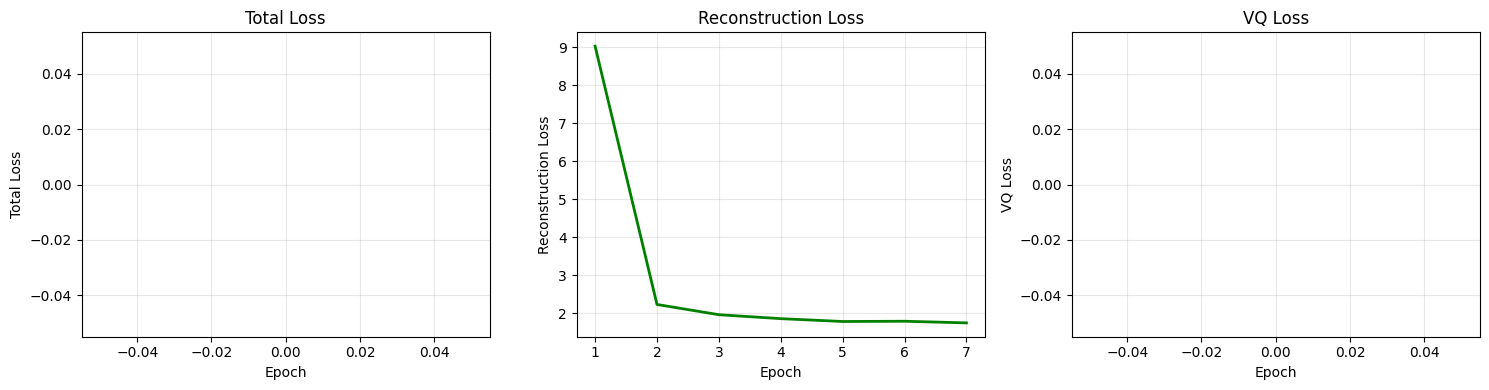


✓ Training curves saved to c:\Users\Administrator\Desktop\IGEM\stage1\notebook-lab\checkpoints\vqvae_end_to_end\training_curves.png


In [ ]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Total loss
axes[0, 0].plot(train_history['epoch'], train_history['total_loss'], 'b-', linewidth=2)
axes[0, 0].set_xlabel('Epoch')
axes[0, 0].set_ylabel('Total Loss')
axes[0, 0].set_title('Total Loss')
axes[0, 0].grid(True, alpha=0.3)

# Reconstruction loss
axes[0, 1].plot(train_history['epoch'], train_history['recon_loss'], 'g-', linewidth=2)
axes[0, 1].set_xlabel('Epoch')
axes[0, 1].set_ylabel('Reconstruction Loss')
axes[0, 1].set_title('Reconstruction Loss')
axes[0, 1].grid(True, alpha=0.3)

# VQ loss
axes[1, 0].plot(train_history['epoch'], train_history['vq_loss'], 'r-', linewidth=2)
axes[1, 0].set_xlabel('Epoch')
axes[1, 0].set_ylabel('VQ Loss')
axes[1, 0].set_title('VQ Loss (⚠️ 上升表示 Codebook Collapse)')
axes[1, 0].grid(True, alpha=0.3)

# Codebook usage
axes[1, 1].plot(train_history['epoch'], 
                [usage * 100 for usage in train_history['codebook_usage']], 
                'purple', linewidth=2, marker='o')
axes[1, 1].set_xlabel('Epoch')
axes[1, 1].set_ylabel('Codebook Usage (%)')
axes[1, 1].set_title('Codebook Usage (应该保持高位)')
axes[1, 1].grid(True, alpha=0.3)
axes[1, 1].axhline(y=50, color='orange', linestyle='--', label='50% threshold')
axes[1, 1].axhline(y=25, color='red', linestyle='--', label='25% threshold (危险)')
axes[1, 1].legend()

plt.tight_layout()
plt.savefig(CHECKPOINT_DIR / 'training_curves_with_codebook.png', dpi=150, bbox_inches='tight')
plt.show()

print(f'\n✓ Training curves saved to {CHECKPOINT_DIR / "training_curves_with_codebook.png"}')

# 打印诊断信息
print('\n' + '=' * 70)
print('Codebook Collapse 诊断')
print('=' * 70)
final_usage = train_history['codebook_usage'][-1] * 100
if final_usage < 25:
    print(f'⚠️ 严重 Codebook Collapse！只使用了 {final_usage:.1f}% 的 codes')
    print('建议：')
    print('  1. 增大 commitment_weight（当前 0.25 → 0.5）')
    print('  2. 启用 kmeans_init')
    print('  3. 减小 VQ 权重（当前 0.1 → 0.05）')
elif final_usage < 50:
    print(f'⚠️ 中度 Codebook Collapse，使用了 {final_usage:.1f}% 的 codes')
    print('建议：调整 commitment_weight 或 VQ 权重')
else:
    print(f'✅ Codebook 使用正常，使用了 {final_usage:.1f}% 的 codes')

## Step 9：推理验证

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

print('\n[Codebook Analysis] 分析 codebook 的正交性...')

# 获取 codebook 向量
with torch.no_grad():
    # 访问 VQ layer 的 codebook
    if hasattr(vqvae_model, 'vector_quantizer'):
        vq_layer = vqvae_model.vector_quantizer
        
        # 获取 codebook embeddings
        if hasattr(vq_layer, 'codebook'):
            codebook = vq_layer.codebook  # (codebook_size, dim)
        elif hasattr(vq_layer, '_codebook'):
            codebook = vq_layer._codebook.embed
        else:
            print('⚠️ 无法访问 codebook')
            codebook = None
        
        if codebook is not None:
            codebook_np = codebook.cpu().numpy()
            
            # 1. 计算 codebook 向量的相似度矩阵（采样前 100 个 codes）
            n_sample = min(100, codebook_np.shape[0])
            codebook_sample = codebook_np[:n_sample]
            
            # 归一化
            codebook_norm = codebook_sample / (np.linalg.norm(codebook_sample, axis=1, keepdims=True) + 1e-8)
            
            # 计算相似度矩阵（余弦相似度）
            similarity_matrix = np.dot(codebook_norm, codebook_norm.T)
            
            # 2. 可视化
            fig, axes = plt.subplots(1, 3, figsize=(18, 5))
            
            # 2.1 相似度矩阵热图
            sns.heatmap(similarity_matrix, cmap='coolwarm', center=0, 
                       vmin=-1, vmax=1, ax=axes[0], cbar_kws={'label': 'Cosine Similarity'})
            axes[0].set_title(f'Codebook Similarity Matrix (前 {n_sample} codes)')
            axes[0].set_xlabel('Code Index')
            axes[0].set_ylabel('Code Index')
            
            # 2.2 非对角元素的分布（正交性指标）
            off_diagonal = similarity_matrix[~np.eye(n_sample, dtype=bool)]
            axes[1].hist(off_diagonal, bins=50, alpha=0.7, color='blue', edgecolor='black')
            axes[1].axvline(x=0, color='red', linestyle='--', linewidth=2, label='Perfect Orthogonal')
            axes[1].set_xlabel('Cosine Similarity')
            axes[1].set_ylabel('Frequency')
            axes[1].set_title('非对角元素分布（越接近 0 越正交）')
            axes[1].legend()
            axes[1].grid(True, alpha=0.3)
            
            # 统计信息
            mean_sim = np.abs(off_diagonal).mean()
            max_sim = np.abs(off_diagonal).max()
            axes[1].text(0.05, 0.95, 
                        f'Mean |similarity|: {mean_sim:.4f}\nMax |similarity|: {max_sim:.4f}',
                        transform=axes[1].transAxes, 
                        verticalalignment='top',
                        bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))
            
            # 2.3 Codebook 向量的范数分布
            norms = np.linalg.norm(codebook_np, axis=1)
            axes[2].hist(norms, bins=50, alpha=0.7, color='green', edgecolor='black')
            axes[2].set_xlabel('L2 Norm')
            axes[2].set_ylabel('Frequency')
            axes[2].set_title('Codebook 向量范数分布')
            axes[2].grid(True, alpha=0.3)
            
            # 统计信息
            mean_norm = norms.mean()
            std_norm = norms.std()
            axes[2].text(0.05, 0.95, 
                        f'Mean norm: {mean_norm:.4f}\nStd norm: {std_norm:.4f}',
                        transform=axes[2].transAxes, 
                        verticalalignment='top',
                        bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))
            
            plt.tight_layout()
            plt.savefig(CHECKPOINT_DIR / 'codebook_orthogonality.png', dpi=150, bbox_inches='tight')
            plt.show()
            
            print(f'\n✓ Codebook 分析完成')
            print(f'  - Codebook size: {codebook_np.shape[0]}')
            print(f'  - Codebook dim: {codebook_np.shape[1]}')
            print(f'  - Mean |similarity| (非对角): {mean_sim:.4f} (越小越好，理想值接近 0)')
            print(f'  - Max |similarity| (非对角): {max_sim:.4f}')
            print(f'  - Mean norm: {mean_norm:.4f}')
            
            # 正交性评分
            if mean_sim < 0.1:
                print(f'\n✅ 正交性优秀！Codebook 向量高度分离')
            elif mean_sim < 0.3:
                print(f'\n✅ 正交性良好')
            elif mean_sim < 0.5:
                print(f'\n⚠️ 正交性一般，建议增大 orthogonal_reg_weight')
            else:
                print(f'\n❌ 正交性较差，存在严重的代码冗余')
                print(f'   建议：增大 orthogonal_reg_weight (当前 10 → 20)')
    else:
        print('⚠️ 模型中没有 vector_quantizer 属性')

In [ ]:
print('\n[Inference] Testing trained model...')

# 设置为评估模式
gcpnet_encoder.eval()
featuriser.eval()
feature_projector.eval()
vqvae_model.eval()

# 随机选择一个样本
test_idx = np.random.randint(0, len(dataset))
edge_feats, mask = dataset[test_idx]
edge_feats = edge_feats.unsqueeze(0).to(device)  # (1, L, 641)
mask = mask.unsqueeze(0).to(device)  # (1, L)
nan_mask = torch.ones_like(mask)

with torch.no_grad():
    # 投影
    projected_feats = feature_projector(edge_feats)  # (1, L, 128)
    
    # 编码
    outputs = vqvae_model(projected_feats, mask, nan_mask)
    decoder_output, indices, vq_loss, _, _, _, _, _ = outputs
    
    # 计算重建误差
    valid_len = mask[0].sum().item()
    original = edge_feats[0, :valid_len].cpu().numpy()
    reconstructed = decoder_output[0, :valid_len].cpu().numpy()
    
    mse = ((original - reconstructed) ** 2).mean()
    
    # 检查是否是 Residual VQ
    if indices.dim() == 3:
        # Residual VQ: (B, L, num_quantizers)
        codes = indices[0, :valid_len].cpu().numpy()
        print(f'\nTest sample {test_idx}:')
        print(f'  Valid edges: {valid_len}')
        print(f'  Reconstruction MSE: {mse:.6f}')
        print(f'  Residual VQ depth: {codes.shape[1]}')
        
        # 统计每层的 unique codes
        for layer in range(codes.shape[1]):
            layer_codes = codes[:, layer]
            unique_codes = len(np.unique(layer_codes))
            print(f'  Layer {layer} unique codes: {unique_codes} / 4096')
            print(f'  Layer {layer} codes sample: {layer_codes[:10]}')
    else:
        # 单层 VQ: (B, L)
        codes = indices[0, :valid_len].cpu().numpy()
        unique_codes = len(np.unique(codes))
        print(f'\nTest sample {test_idx}:')
        print(f'  Valid edges: {valid_len}')
        print(f'  Reconstruction MSE: {mse:.6f}')
        print(f'  Unique codes used: {unique_codes} / 4096')
        print(f'  Codes sample: {codes[:10]}')

print('\n✓ 推理验证完成！')

## Step 10：导出 edge codes（可选）

In [ ]:
print('\n[Export] Encoding all edges to codes...')

# 设置为评估模式
gcpnet_encoder.eval()
featuriser.eval()
feature_projector.eval()
vqvae_model.eval()

all_codes = []
all_meta = []

with torch.no_grad():
    for idx in range(len(dataset)):
        if (idx + 1) % 100 == 0:
            print(f'  Progress: {idx+1}/{len(dataset)}', end='\r')
        
        edge_feats, mask = dataset[idx]
        edge_feats = edge_feats.unsqueeze(0).to(device)
        mask = mask.unsqueeze(0).to(device)
        nan_mask = torch.ones_like(mask)
        
        # 编码
        projected_feats = feature_projector(edge_feats)
        outputs = vqvae_model(projected_feats, mask, nan_mask)
        _, indices, _, _, _, _, _, _ = outputs
        
        # 提取有效 codes
        valid_len = mask[0].sum().item()
        codes = indices[0, :valid_len].cpu().numpy()
        
        all_codes.extend(codes.tolist())
        all_meta.extend([idx] * len(codes))

print(f'\n  Total codes: {len(all_codes)}')

# 保存为 CSV
codes_df = pd.DataFrame({
    'graph_index': all_meta,
    'edge_code': all_codes,
})

output_csv = BASE_DIR / 'binding_edge_codes_end_to_end.csv'
codes_df.to_csv(output_csv, index=False)

print(f'\n✓ Edge codes saved to {output_csv}')
print(f'  Unique codes: {codes_df["edge_code"].nunique()} / 4096')
print(f'  Code usage: {codes_df["edge_code"].nunique() / 4096 * 100:.2f}%')

## 总结

### 端到端训练 vs 冻结 GCPNet

| 项目 | 冻结 GCPNet | 端到端训练 |
|------|------------|----------|
| **训练速度** | 快 | 慢（约 2-3 倍） |
| **显存占用** | 低 | 高（需减小 batch size） |
| **收敛速度** | 快 | 慢（需更多 epoch） |
| **最终效果** | 依赖预训练质量 | 理论上更好（联合优化） |
| **适用场景** | 预训练特征已足够好 | 需要针对任务微调特征 |

### 建议

1. **先冻结训练**：用 `binding_edge_codebook.ipynb` 快速验证流程
2. **再端到端微调**：如果效果不理想，使用本 notebook 进行端到端优化
3. **监控过拟合**：端到端训练更容易过拟合，建议加入验证集
4. **调整超参数**：
   - GCPNet 学习率：1e-6 ~ 1e-5
   - 其他模块学习率：1e-4 ~ 1e-3
   - Batch size：2-4（根据显存）
   - Gradient clip：0.5-1.0

### 下一步

- 添加验证集评估
- 实现 early stopping
- 对比冻结 vs 端到端的效果
- 可视化学到的 codes 分布